In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.preprocessing.image import ImageDataGenerator

2023-05-04 10:57:27.730170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 10:57:28.032525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 10:57:28.033913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 10:57:33.680158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow import transpose
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
images = pd.read_csv("train.csv")

In [5]:
y = images['label']
X = images.drop("label",axis = 1)
X = X.values.reshape(-1,28,28,1)
X = X/255

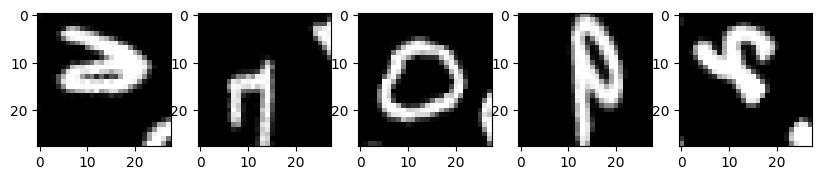

In [6]:
# Create a data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,      # randomly rotate the images by up to 10 degrees
    zoom_range=0.3,         # randomly zoom the images by up to 10%
    width_shift_range=0.2,  # randomly shift the images horizontally by up to 10%
    height_shift_range=0.15, # randomly shift the images vertically by up to 10%
    horizontal_flip=True,   # randomly flip the images horizontally
    vertical_flip=False,    # don't randomly flip the images vertically
    fill_mode='reflect'     # fill any empty pixels with the nearest value
)

# Fit the data generator to the training data
datagen.fit(X)

# Generate augmented data
augmented_data = datagen.flow(X, y, batch_size=22000)

# generate a batch of augmented data
X_augmented, y_augmented = next(augmented_data)

# concatenate the augmented data with the original training data
X = np.concatenate((X, X_augmented))
y = np.concatenate((y, y_augmented))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)


# Plot a few examples of the augmented data
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(augmented_data[0][0][i].reshape(28, 28), cmap='gray')
plt.show()

In [23]:
model = Sequential()
model.add(BatchNormalization(input_shape=(28,28,1)))
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation ="softmax"))

In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
early_stopping = EarlyStopping(
    monitor = 'val_loss', # monitor the validation loss during training and stop training if there is no improvement in the validation loss for 2 consecutive epochs.
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=4, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [26]:
# Train the model with 20 epochs
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks = [early_stopping]
)

Epoch 1/15
1400/1400 [==============================] - 41s 28ms/step - loss: 0.7702 - accuracy: 0.7495 - val_loss: 0.4334 - val_accuracy: 0.8561
Epoch 2/15
1400/1400 [==============================] - 45s 32ms/step - loss: 0.4378 - accuracy: 0.8586 - val_loss: 0.3130 - val_accuracy: 0.8985
Epoch 3/15
1400/1400 [==============================] - 47s 34ms/step - loss: 0.3402 - accuracy: 0.8888 - val_loss: 0.2598 - val_accuracy: 0.9178
Epoch 4/15
1400/1400 [==============================] - 47s 34ms/step - loss: 0.2906 - accuracy: 0.9051 - val_loss: 0.2314 - val_accuracy: 0.9278
Epoch 5/15
1400/1400 [==============================] - 42s 30ms/step - loss: 0.2556 - accuracy: 0.9155 - val_loss: 0.2143 - val_accuracy: 0.9327
Epoch 6/15
1400/1400 [==============================] - 36s 26ms/step - loss: 0.2297 - accuracy: 0.9238 - val_loss: 0.1982 - val_accuracy: 0.9363
Epoch 7/15
1400/1400 [==============================] - 37s 26ms/step - loss: 0.2098 - accuracy: 0.9300 - val_loss: 0.1933 -

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)

600/600 [==============================] - 4s 7ms/step - loss: 0.1663 - accuracy: 0.9502


In [28]:
y_pred = model.predict(X_test)

600/600 [==============================] - 4s 7ms/step


In [29]:
y_pred_classes = np.argmax(y_pred, axis = 1)

In [30]:
y_true = y_test.astype(int).tolist()

In [31]:
confusion = confusion_matrix(y_true, y_pred_classes)
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1834
           1       0.98      0.99      0.99      2091
           2       0.94      0.90      0.92      1911
           3       0.95      0.94      0.95      2025
           4       0.96      0.96      0.96      1842
           5       0.95      0.90      0.92      1765
           6       0.94      0.96      0.95      1927
           7       0.92      0.97      0.94      1987
           8       0.96      0.95      0.95      1891
           9       0.95      0.94      0.95      1927

    accuracy                           0.95     19200
   macro avg       0.95      0.95      0.95     19200
weighted avg       0.95      0.95      0.95     19200



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


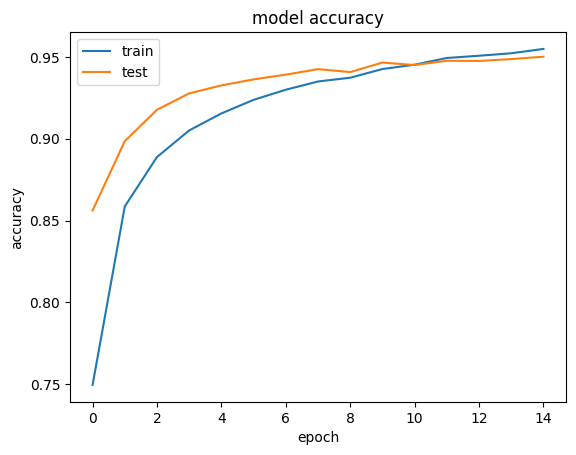

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Save the entire model to a HDF5 file
model.save("modail.h5")

In [ ]:
# Get the weights of the first convolutional layer
weights = model.layers[1].get_weights()[0]

# Normalize the weights
weights = weights - weights.min()
weights = weights / weights.max()

# Transpose the weight tensor to have the filter index as the first dimension
weights = transpose(weights, [3, 0, 1, 2])

# Plot the filters
n_filters = weights.shape[0]
n_columns = 8
n_rows = n_filters // n_columns + 1

fig = plt.figure(figsize=(12, 8))
for i in range(n_filters):
    ax = fig.add_subplot(n_rows, n_columns, i + 1)
    ax.imshow(weights[i])
    ax.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Model
# Select an input image from the training data
x = X_train[0]
x = np.expand_dims(x, axis=0)

# Get the feature maps of the first convolutional layer
layer_name = 'conv2d_3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(x)

# Plot the feature maps
n_filters = intermediate_output.shape[-1]
n_columns = 8
n_rows = n_filters // n_columns + 1

fig = plt.figure(figsize=(12, 8))
for i in range(n_filters):
    ax = fig.add_subplot(n_rows, n_columns, i + 1)
    ax.imshow(intermediate_output[0, :, :, i])
    ax.axis('off')

In [ ]:
# Select an input image from the training data
x = X_train[0]
x = np.expand_dims(x, axis=0)

# Get the feature maps of the first convolutional layer
layer_name = 'max_pooling2d_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(x)

# Plot the feature maps
n_filters = intermediate_output.shape[-1]
n_columns = 8
n_rows = n_filters // n_columns + 1

fig = plt.figure(figsize=(12, 8))
for i in range(n_filters):
    ax = fig.add_subplot(n_rows, n_columns, i + 1)
    ax.imshow(intermediate_output[0, :, :, i])
    ax.axis('off')

In [ ]:
['batch_normalization_7', 'conv2d_21', 'max_pooling2d_20', 'dropout_10', 'conv2d_22', 'max_pooling2d_21', 'conv2d_23', 'dropout_11', 'flatten_7', 'dense_14', 'dense_15']